In [1]:
import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm 
import cv2

from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
import warnings

warnings.simplefilter('ignore')

## Доступ к датасету

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train/"
DIR_TEST = "/content/drive/My Drive/class_special_machinery/test_dataset_test/test/"

PATH_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train.csv"
PATH_TEST = "/content/drive/My Drive/class_special_machinery/test_dataset_test/test.csv"

## Класс для загрузки датасета

In [4]:
class ImageDataset(Dataset):
    def __init__(self, data_df, transform=None):

        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        # достаем имя изображения и ее лейбл
        image_name, label = self.data_df.iloc[idx]['ID_img'], self.data_df.iloc[idx]['class']

        # читаем картинку
        image = cv2.imread(DIR_TRAIN + f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()
    
    def __len__(self):
        return len(self.data_df)

In [5]:
# задаем преобразование изображения.

train_transform = transforms.Compose([
    transforms.Resize(256), 
    transforms.RandomResizedCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(0, 30)),
    #transforms.Grayscale(),
    #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    #transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(244),
    #transforms.Grayscale(),
    #transforms.RandomResizedCrop(256),
    #transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

## Таблица с разметкой датасета

In [ ]:
data_df = pd.read_csv(PATH_TRAIN)
data_df.head()

,ID_img,class
0,2138.jpg,4.0
1,2139.jpg,6.0
2,2140.jpg,3.0
3,2141.jpg,6.0
4,2142.jpg,3.0


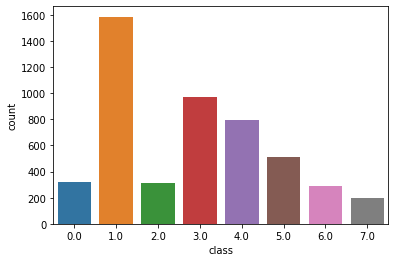

In [ ]:
sns.countplot(x="class" , data=data_df)

Выводы: в тренировочном датасете на лицо сильный дисбаланс классов.

## Исследование изображений

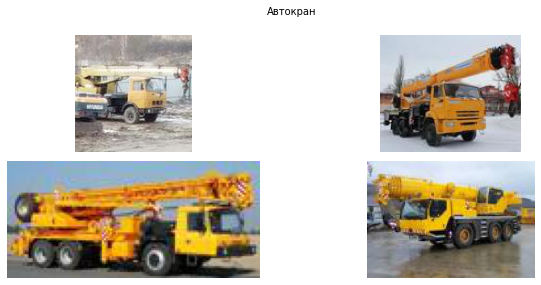

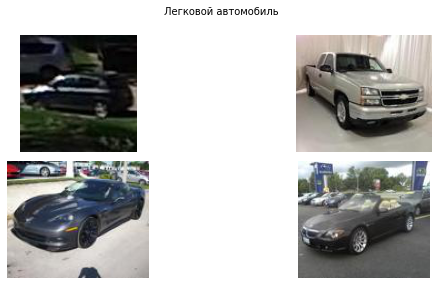

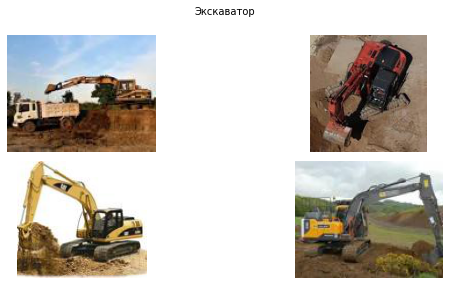

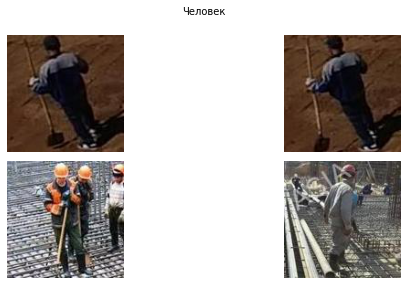

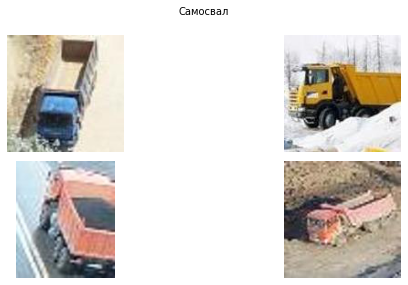

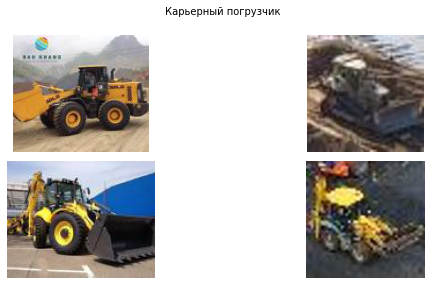

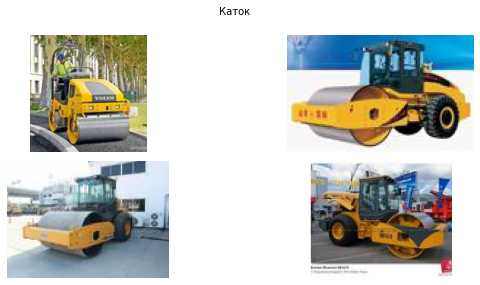

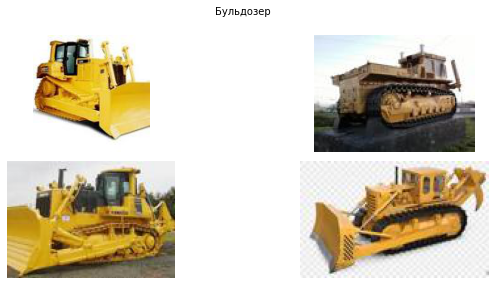

In [ ]:
from torch._C import Value
# посмотрим на картинки
class_dict = {
    'Автокран': 0, 
    'Легковой автомобиль': 1,
    'Экскаватор': 2,
    'Человек': 3,
    'Самосвал': 4,
    'Карьерный погрузчик': 5,
    'Каток': 6,
    'Бульдозер': 7
    }

for name, number in class_dict.items():
  fig, axs = plt.subplots(2, 2, figsize=(10,4))
  fig.suptitle(f'{name}', fontsize=10)

  for i, name in zip(range(4), data_df[ data_df['class'] == number ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)].axis('off')

  fig.tight_layout()
  fig.subplots_adjust(top=0.88)

Выводы:
1. Картинки разного размера
2. Есть изображения с несколькими объектами
3. Есть повторяющиеся изображения
4. Изображения явно не только с камер видеонаблюдения
5. У некоторых изображений отсутсвует фон
6. Есть некорректно размеченные данные, например карьерный погрузчик с гусеницами (хотя это указано, как одно из главных различий с бульдозером)

## Обработка изображений

Обработка заключалась в удаления фона изображения с помощью библиотеки rmbg. Здесь представлен пример кода

In [ ]:
# from rembg import remove

input_path = DIR_TRAIN + '2139.jpg'
output_path = 'out.png'

input = cv2.imread(input_path)
output = remove(input)
cv2.imwrite(output_path, output)

cv2_imshow(output)

## Исследование модели

### Подготовка выборок

In [ ]:
# разделим датасет на трейн и валидацию, чтобы смотреть на качество
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)

In [ ]:
train_df.shape, valid_df.shape

((3992, 2), (998, 2))

In [ ]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

### Вспомогательные функции

In [15]:
def crossvalid(res_model=None,criterion=None,optimizer=None,dataset=None,k_fold=5):
    
    train_score = pd.Series()
    val_score = pd.Series()
    
    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    # tr:train,val:valid; r:right,l:left;  eg: trrr: right index of right side train subset 
    # index: [trll,trlr],[vall,valr],[trrl,trrr]
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size
        
        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))
        
        train_indices = train_left_indices + train_right_indices
        val_indices = list(range(vall,valr))
        
        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)
        
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=50,
                                          shuffle=True, num_workers=4)
        train_acc = train(res_model,criterion,optimizer,train_loader,val_loader,1)
        train_score.at[i] = train_acc
        val_acc = valid(res_model,criterion,optimizer,val_loader)
        val_score.at[i] = val_acc
    
    return train_score,val_score

In [16]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    dd = list(map(lambda x: x.cpu().detach().numpy(), train_history))
    plt.plot(dd, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [17]:
def train(res_model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []
    
    train_acc_log = []
    val_acc_log = []
    
    for epoch in tqdm(range(NUM_EPOCH)):
        model.train()
        train_loss = 0.
        train_size = 0
        
        train_pred = 0.

        for imgs, labels in train_dataloader:
            optimizer.zero_grad()

            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()
            
            train_loss += loss.item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data / y_pred.size(0))
            
            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0
        
        val_pred = 0.
        
        model.eval()
        
        with torch.no_grad():
            for imgs, labels in test_dataloader:
                
                imgs = imgs.cuda()
                labels = labels.cuda()
                
                pred = model(imgs)
                loss = criterion(pred, labels)
                
                val_loss += loss.item()
                val_size += pred.size(0)
                
                val_pred += (pred.argmax(1) == labels).sum()
        

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')
        


        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

### Загружаем и обучаем модель

In [ ]:
# Подргружаем модель и установим выход равный числу классов

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

### На исходных данных

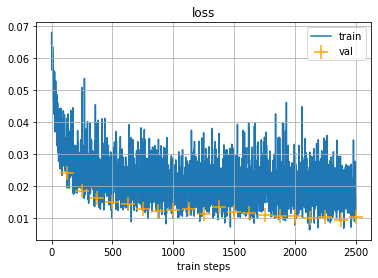

100%|██████████| 20/20 [55:42<00:00, 167.15s/it]

Train loss: 1.863900740782101
Val loss: 1.0267757889040128
Train acc: tensor(80.3357, device='cuda:0')
Val acc: tensor(89.4790, device='cuda:0')


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer, train_loader, valid_loader, 20)

In [ ]:
model.eval()
torch.save(model, "/content/drive/My Drive/model_resnet50_original_dataset.pth")
# print("Saved PyTorch Model State to model.pth")

In [ ]:
# model = torch.load(/content/drive/My Drive/model_resnet101.pth)
# model.eval()

Посмотрим метрики нашей итоговой модели на валидации.

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

100%|██████████| 32/32 [00:05<00:00,  5.50it/s]


Посчитаем recall

In [ ]:
valid_df["pred"] = valid_predicts
val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.8446829475713581


### На обработанных данных

In [ ]:
DIR_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train_rmbg/"
PATH_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train.csv"

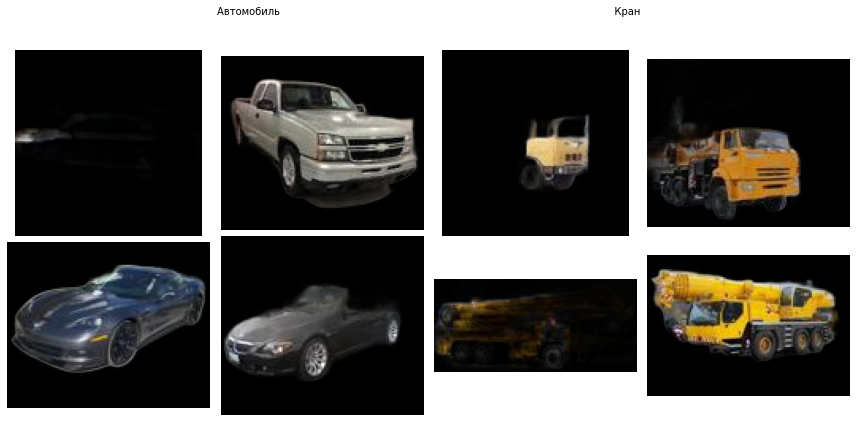

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(12,6))
fig.suptitle(f'Автомобиль {" "*105} Кран', fontsize=10)

for i, name in zip(range(4), data_df[ data_df['class'] == 1 ].sample(4, random_state=42)['ID_img']):
    axs[i // 2, (i % 2)].imshow(plt.imread(DIR_TRAIN + f"{name}"))
    axs[i // 2, (i % 2)].axis('off')

for i, name in zip(range(4), data_df[ data_df['class'] == 0 ].sample(4, random_state=42)['ID_img']):
  axs[i // 2, (i % 2)+2].imshow(plt.imread(DIR_TRAIN + f"{name}"))
  axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 8)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

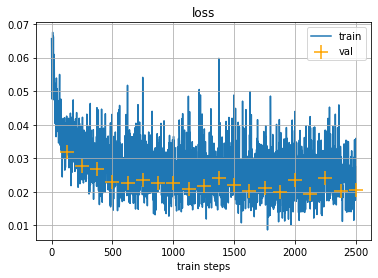

100%|██████████| 20/20 [56:26<00:00, 169.31s/it]

Train loss: 2.3814227820219163
Val loss: 2.066671941242739
Train acc: tensor(74.2736, device='cuda:0')
Val acc: tensor(77.4549, device='cuda:0')


In [ ]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer, train_loader, valid_loader, 20)

In [ ]:
model.eval()
torch.save(model, "/content/drive/My Drive/class_special_machinery/model_resnet50_rmbg_dataset.pth")
# print("Saved PyTorch Model State to model.pth")

In [ ]:
# model = torch.load(/content/drive/My Drive/model_resnet101.pth)
# model.eval()

In [ ]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

valid_df["pred"] = valid_predicts

val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

100%|██████████| 32/32 [00:05<00:00,  5.58it/s]

Validation accuracy = 0.6627822430833359


### На смешанных данных

In [6]:
model = models.resnet50(pretrained=True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)

model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [7]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

In [8]:
DIR_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train_default_and_rmbg/"
PATH_TRAIN = "/content/drive/My Drive/class_special_machinery/train_dataset_train/train_common.csv"

In [9]:
data_df = pd.read_csv(PATH_TRAIN)
data_df.shape

(9980, 2)

Добавляем обработанные изображения только в самые малочисленные категории

In [10]:
for i in range(len(data_df)):
    if int(data_df['ID_img'][i].split('.')[0]) >= 9000 and data_df['class'][i] not in [0, 2, 5, 6, 7]:
        data_df = data_df.drop(i)

data_df.shape

(6628, 2)

In [11]:
train_df, valid_df = train_test_split(data_df, test_size=0.2, random_state=43)
train_df.shape, valid_df.shape

((5302, 2), (1326, 2))

In [12]:
train_dataset = ImageDataset(train_df, train_transform)
valid_dataset = ImageDataset(valid_df, valid_transform)

In [27]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=32,
                                           #shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

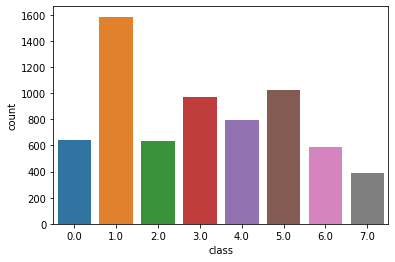

In [ ]:
sns.countplot(x="class" , data=data_df)

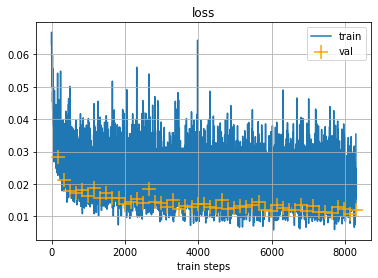

100%|██████████| 50/50 [1:19:07<00:00, 94.95s/it]

Train loss: 1.9325620026486814
Val loss: 1.2030347894461402
Train acc: tensor(79.4417, device='cuda:0')
Val acc: tensor(86.2745, device='cuda:0')


In [18]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model, criterion, optimizer, train_loader, valid_loader, 50)

In [19]:
model.eval()
torch.save(model, "/content/drive/My Drive/class_special_machinery/model_resnet50_mix.pth")
# print("Saved PyTorch Model State to model.pth")

In [ ]:
# model = torch.load(/content/drive/My Drive/model_resnet101.pth)
# model.eval()

In [28]:
model.eval()
valid_predicts = []

for imgs, _ in tqdm(valid_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)

    pred_numpy = pred.cpu().detach().numpy()

    for class_obj in pred_numpy:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      valid_predicts.append(index)

valid_df["pred"] = valid_predicts

val_accuracy = recall_score(valid_df['class'].values, valid_df['pred'].values, average = "macro")

print(f"Validation accuracy = {val_accuracy}")

100%|██████████| 42/42 [00:07<00:00,  5.67it/s]

Validation accuracy = 0.8550140500498056


In [29]:
valid_df.head()

,ID_img,class,pred
1023,3161.jpg,2.0,4
1324,3462.jpg,2.0,2
8069,12079.jpg,7.0,7
6122,10132.jpg,5.0,5
4230,6368.jpg,1.0,1


### Матрица ошибок

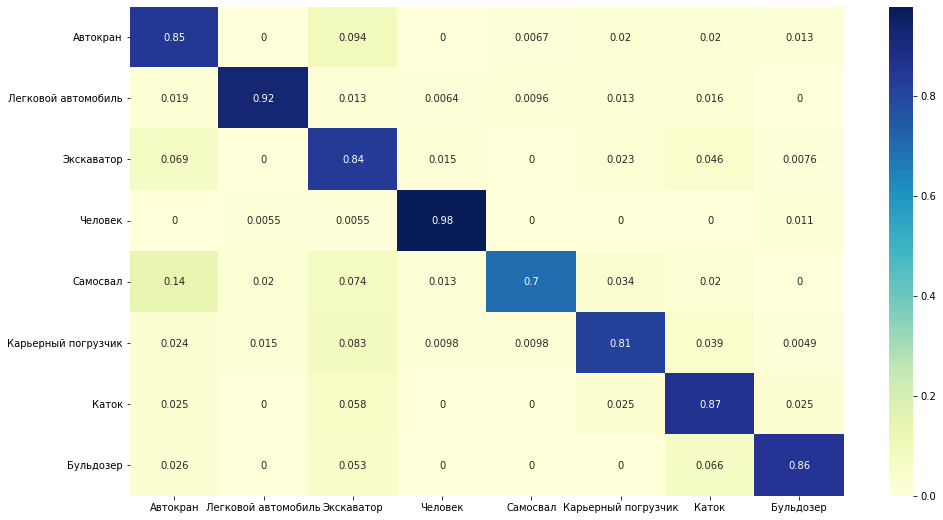

In [ ]:
cm = confusion_matrix(valid_df['class'], valid_df['pred'])

df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], index = [
    i for i in ['Автокран', 'Легковой автомобиль', 'Экскаватор', 'Человек', 'Самосвал', 'Карьерный погрузчик', 'Каток', 'Бульдозер']
    ],
    columns = [i for i in ['Автокран', 'Легковой автомобиль', 'Экскаватор', 'Человек', 'Самосвал', 'Карьерный погрузчик', 'Каток', 'Бульдозер']])

plt.figure(figsize = (16,9))
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

## Предсказываем нашей моделью результат

In [ ]:
test_df = pd.read_csv(PATH_TEST)
test_df = test_df.drop(["class"], axis = 1)

In [ ]:
class TestImageDataset(Dataset):
    def __init__(self, data_df, transform=None):
        self.data_df = data_df
        self.transform = transform

    def __getitem__(self, idx):
        image_name = self.data_df.iloc[idx]['ID_img']
        
        # читаем картинку
        image = cv2.imread(DIR_TEST+ f"{image_name}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        # преобразуем, если нужно
        if self.transform:
            image = self.transform(image)
        
        return image
    
    def __len__(self):
        return len(self.data_df)

In [ ]:
test_dataset = TestImageDataset(test_df, valid_transform)

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32,
                                           # shuffle=True,
                                           pin_memory=True,
                                           num_workers=2)

In [ ]:
model.eval()
predicts = []

for imgs in tqdm(test_loader):
    
    imgs = imgs.cuda()
    pred = model(imgs)
    for class_obj in pred:
      index, max_value = max(enumerate(class_obj), key=lambda i_v: i_v[1])
      predicts.append(index)

In [ ]:
test_df["class"] = predicts

test_df.head()

,ID_img,class
0,0.jpg,5
1,1.jpg,7
2,2.jpg,1
3,3.jpg,2
4,4.jpg,6


In [ ]:
test_df.to_csv("/content/drive/My Drive/submit_original_dataset.csv", index=False)